# **CASCADE #1**

In [2]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, 
make_scorer, precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
import warnings
from xgboost import XGBClassifier

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")


In [3]:
def log_likelihood(y_true, y_pred):
    """Calculate the log-likelihood loss between true labels and predicted labels.
    
    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_pred (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).
    
    Returns:
        float: Negative log-likelihood loss value.
    """

    # To prevent log(0)
    epsilon = 1e-7 
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Compute the log likelihood
    log_likelihood = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    return -np.sum(log_likelihood)

In [4]:
def find_optimal_threshold(y_true, y_proba):
    """Find the optimal threshold for binary classification based on ROC curve.

    This function computes the Receiver Operating Characteristic (ROC) curve
    and then finds the threshold where the difference between True Positive Rate (TPR)
    and False Positive Rate (FPR) is maximized.

    Args:
        y_true (numpy.ndarray): Array of true labels (0 or 1). Shape should be (n_samples,).
        y_proba (numpy.ndarray): Array of predicted probabilities for being label 1. Shape should be (n_samples,).

    Returns:
        float: The optimal threshold for binary classification.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [5]:
def apply_smote(X_train, y_train):
    """Apply Synthetic Minority Over-sampling Technique (SMOTE) to training data.
    
    This function balances the class distribution in the training set by generating
    synthetic samples for the minority class using SMOTE.

    Args:
        X_train (numpy.ndarray or pandas.DataFrame): Training features. Shape should be (n_samples, n_features).
        y_train (numpy.ndarray or pandas.Series): Training labels. Shape should be (n_samples,).

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: Resampled training features and labels.
        
        - X_train_res (numpy.ndarray): Resampled training features. Shape will be (n_resampled_samples, n_features).
        - y_train_res (numpy.ndarray): Resampled training labels. Shape will be (n_resampled_samples,).
    """
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

In [6]:
def create_poly_features(df, include_list=['PATIENT_AGE_AT_TREATMENT',
       'TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI'], degree=2):
    """
    Generates polynomial features with coherent names.

    Args:
        df (DataFrame): A pandas DataFrame containing the features.
        include_list (list): List of original features for which squared terms should be included.
        degree (int): The degree of the polynomial features. Default is 2.
    
    Returns:
        DataFrame: A new DataFrame with the polynomial features.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df)

    # Generate coherent names
    poly_feature_names = []
    
    for d in range(1, degree+1):
        comb = combinations_with_replacement(df.columns, d)
        for i in list(comb):
            if len(set(i)) == 1:  # all elements in the combination are the same
                if d == 1: # no need to show power for d=1
                    poly_feature_names.append(i[0])
                else:
                    poly_feature_names.append(i[0] + "^" + str(d))
            else:
                poly_feature_names.append(" ".join(i))

    # Create a new DataFrame
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    if include_list is not None:
        # List of columns to drop
        drop_columns = [col for col in poly_df.columns if "^" in col and col.split("^")[0] not in include_list]
        poly_df.drop(columns=drop_columns, inplace=True)
    
    return poly_df

In [7]:
def model_pipeline(X_train, y_train, X_test, y_test, model, metrics_list, params={},
k=10, stratified=True, AIC=False, smote=False, SHAP=False,
optimal_threshold=True, importances=False, Target=None):
    """Runs a machine learning model pipeline with various options.

    This function constructs a machine learning pipeline with optional techniques such as SMOTE
    and stratified k-fold cross-validation. It trains the model, evaluates it with specified metrics,
    and can optionally calculate AIC/BIC - to be used when dealing with parametric models, feature 
    importances, SHAP values, and optimal thresholds.

    Args:
        X_train (pandas.DataFrame): Training data.
        y_train (pandas.Series): Training labels.
        X_test (pandas.DataFrame): Test data.
        y_test (pandas.Series): Test labels.
        model (object): Uninitialized machine learning model.
        metrics_list (list of str): List of metrics to evaluate. Must be keys in the 'metrics' dictionary.
        params (dict, optional): Parameters to pass to the model. Default is an empty dictionary.
        k (int, optional): Number of folds in KFold cross-validation. Default is 10.
        stratified (bool, optional): Whether to use StratifiedKFold. Default is True.
        AIC (bool, optional): Whether to compute Akaike Information Criterion. Default is False.
        smote (bool, optional): Whether to use SMOTE for oversampling. Default is False.
        SHAP (bool, optional): Whether to compute SHAP values. Default is False.
        optimal_threshold (bool, optional): Whether to find optimal threshold for classification. Default is True.
        importances (bool, optional): Whether to compute feature importances. Default is False.
        Target (string, optional): The name of the type of target being predicted. Default is None - will display conf. matrix for live birth.

    Returns:
        dict: Dictionary containing various evaluation results such as cross-validation scores,
            test scores, feature importances, and more. The specific keys depend on the input arguments.
    """

    # Map metric names to functions
    metrics = {
        'accuracy': balanced_accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1_score': f1_score,
        'auc': roc_auc_score,
        }

    # Create a pipeline with the specified model and parameters
    steps = []

    # Check if SMOTE is requested and apply it within the pipeline to the training data
    if smote:
        steps.append(('smote', SMOTE()))
        
    steps.append(('model', model(**params)))
    pipeline = ImbPipeline(steps)

    # Initialize KFold cross-validation or Stratified KFold if stratified=True
    if stratified:
        cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    else:
        cv = KFold(n_splits=k, shuffle=True, random_state=1)

    # Compute the specified metrics using cross-validation
    cv_results = {}
    thresholds = []
    for metric in metrics_list:
        scorer = make_scorer(metrics[metric])
        cv_scores = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)
            
            # Compute the scores for metric which require a classification threshold
            if optimal_threshold and metric != 'auc':
                y_train_proba_fold = pipeline.predict_proba(X_train_fold)[:, 1]
                threshold = find_optimal_threshold(y_train_fold, y_train_proba_fold)
                thresholds.append(threshold)
            else:
                threshold = 0.5
                
            y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

            if metric == 'auc':
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred_proba))
            else:
                y_val_pred = (y_val_pred_proba >= threshold).astype(int)
                cv_scores.append(scorer._score_func(y_val_fold, y_val_pred))

        # Calculate confidence intervals
        cv_results[metric] = (np.mean(cv_scores), np.std(cv_scores))

    cv_results = pd.DataFrame(cv_results, columns=metrics_list).T
    cv_results.columns = ['Mean', 'Standard Deviation',]
    cv_results = cv_results.T

    # Compute the average optimal threshold from cross-validation
    avg_threshold = np.mean(thresholds) if thresholds else 0.5
    print('Average optimal threshold = ' + str(round(avg_threshold, 3)))

    # Fit the model on the full training set
    pipeline.fit(X_train, y_train)

    # Feature importances
    if importances:
        feature_importances = []
        for train_index, test_index in cv.split(X_train, y_train):
            X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

            pipeline.fit(X_train_fold, y_train_fold)
            fitted_model = pipeline.named_steps['model']

            if hasattr(fitted_model, 'feature_importances_'):
                fold_importance = fitted_model.feature_importances_
            elif hasattr(fitted_model, 'coef_'):
                fold_importance = np.abs(fitted_model.coef_[0])
            else:
                perm_importance = permutation_importance(fitted_model, X_test_fold, y_test_fold)
                fold_importance = perm_importance.importances_mean

            feature_importances.append(fold_importance)

        # Compute mean and standard deviation of feature importances
        feature_importances_mean = np.mean(feature_importances, axis=0)
        feature_importances_std = np.std(feature_importances, axis=0)
        
        importances_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance_mean': feature_importances_mean,
            'importance_std': feature_importances_std
            })
        
        # Sort by importance_mean in descending order
        importances_df = importances_df.sort_values(by='importance_mean', ascending=False)
    
    else:
        importances_df = pd.DataFrame()

    # Compute the specified metrics on the test set
    test_results = {}
    for metric in metrics_list:
        scorer = metrics[metric]
        y_test_proba = pipeline.predict_proba(X_test)[:, 1]
        if metric == 'auc':
            test_score = scorer(y_test, y_test_proba)
        else:
            y_test_pred = (y_test_proba >= avg_threshold).astype(int)
            test_score = scorer(y_test, y_test_pred)
        test_results[metric] = test_score

    test_results = pd.DataFrame(test_results, index=['Value'], columns=metrics_list).T
    test_results = test_results.T

    # Compute the confusion matrix on the test set
    conf_matrix = confusion_matrix(y_test, y_test_pred) 

    # Output mean and std of cross-validation scores and test set scores
    output = {
        'cv_results': cv_results,
        'test_results': test_results,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba, 
    }

    if AIC:
        # Copute Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)
        y_pred_train_prob = pipeline.predict_proba(X_train)[:, 1] # Get predicted probabilities for the positive class
        n = X_train.shape[0] # Number of observations
        k = len(pipeline.named_steps['model'].coef_[0]) + 1 # Number of parameters in the model, adding 1 for intercept
        logL = log_likelihood(y_train, y_pred_train_prob)
        aic = 2 * k - 2 * logL
        bic = np.log(n) * k - 2 * logL
        output['aic'] = aic
        print('AIC: '+str(round(aic, 3)))
        output['bic'] = bic
        print('BIC: '+str(round(bic, 3)))

    output['feature_importances'] = importances_df

    # Print CV results
    print('')
    print('CV RESULTS')
    display(cv_results)
    print('')

    #Print Test results
    print('TEST RESULTS')
    display(test_results)

    if Target == 'oocytes':
        Negative = 'No Oocytes Collected'
        Positive = 'Oocytes Collected'
    elif Target == 'embryos':
        Negative = 'No Embryos Created'
        Positive = 'Embryos Created'
    else:
        Negative = 'No Live Birth'
        Positive = 'Live Birth'

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[Negative, Positive])
    disp.plot(cmap="Oranges",  colorbar=False)
    plt.title('Test Set Confusion Matrix')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('confusion_matrix_lb.png', bbox_inches='tight', dpi=600)
    plt.show()
    print('')

    #Print Features analysis
    if importances:
        print('FEATURES ANALYSIS')
        display(importances_df.head(20))

    if SHAP:
        # Compute SHAP values
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            explainer = shap.TreeExplainer(pipeline.named_steps['model'])
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

        elif hasattr(pipeline.named_steps['model'], 'coef_'):
            explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_train)
            shap_values = explainer.shap_values(X_train)

            # Create a SHAP summary plot
            shap.summary_plot(shap_values, X_train, plot_size=[20,10], max_display=20)

    return output

In [8]:
def compute_grid_search(model, param_grid, X_train, y_train):
    """
    Perform a grid search on a model using Stratified K-Fold cross-validation.
    
    Parameters:
    - model: Estimator or model to be used.
    - param_grid: Dictionary of parameters for grid search.
    - X_train: Training data features.
    - y_train: Training data labels.
    
    Returns:
    - grid_search: Fitted GridSearchCV object.
    """

    # Create StratifiedKFold instance
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Set up the grid search with 'balanced_accuracy' as the scoring metric
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=skf, 
        scoring='balanced_accuracy',  # Using balanced accuracy directly as the scoring metric
        verbose=1,  
        n_jobs=-1   
    )
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    print(grid_search.best_params_)
    
    return grid_search


## **Target Creation and Train Data Filtering**

In [9]:
TRAIN = pd.read_parquet('TRAIN_2016.parquet')
TEST = pd.read_parquet('TEST_2016.parquet')

In [10]:
# Convert FRESH_EGGS_COLLECTED to binary
TRAIN['FRESH_EGGS_COLLECTED'] = (TRAIN['FRESH_EGGS_COLLECTED'] > 0).astype(int)
TRAIN.rename(columns={'FRESH_EGGS_COLLECTED': 'FRESH_EGGS_BINARY'}, inplace=True)

TEST['FRESH_EGGS_COLLECTED'] = (TEST['FRESH_EGGS_COLLECTED'] > 0).astype(int)
TEST.rename(columns={'FRESH_EGGS_COLLECTED': 'FRESH_EGGS_BINARY'}, inplace=True)

print('Stage 1 TRAIN set size: '+str(TRAIN.shape[0]))

Stage 1 TRAIN set size: 33595


In [11]:
# Filter training set for stage 2
TRAIN_STAGE2 = TRAIN[TRAIN['FRESH_EGGS_BINARY'] == 1]
print('Stage 2 TRAIN set size: '+str(TRAIN_STAGE2.shape[0]))

# Convert TOTAL_EMBRYOS_CREATED to binary
TRAIN_STAGE2['TOTAL_EMBRYOS_CREATED'] = (TRAIN_STAGE2['TOTAL_EMBRYOS_CREATED'] > 0).astype(int)
TRAIN_STAGE2.rename(columns={'TOTAL_EMBRYOS_CREATED': 'EMBRYOS_CREATED_BINARY'}, inplace=True)

TEST['TOTAL_EMBRYOS_CREATED'] = (TEST['TOTAL_EMBRYOS_CREATED'] > 0).astype(int)
TEST.rename(columns={'TOTAL_EMBRYOS_CREATED': 'EMBRYOS_CREATED_BINARY'}, inplace=True)

Stage 2 TRAIN set size: 31405



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
# Filter training set for stage 3
TRAIN_STAGE3 = TRAIN[TRAIN['TOTAL_EMBRYOS_CREATED']  > 0]
print('Stage 3 TRAIN set size: '+str(TRAIN_STAGE3.shape[0]))

Stage 3 TRAIN set size: 29856


In [13]:
# Separate the targets from the data

# Stage 1
y_train_eggs = TRAIN['FRESH_EGGS_BINARY']
y_test_eggs = TEST['FRESH_EGGS_BINARY']
X_train_eggs = TRAIN.drop(['FRESH_EGGS_BINARY', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE', 'SPECIFIC_TREATMENT_TYPE_IVF'], axis=1)
X_test_eggs = TEST.drop(['FRESH_EGGS_BINARY', 'EMBRYOS_CREATED_BINARY', 'LIVE_BIRTH_OCCURRENCE', 'SPECIFIC_TREATMENT_TYPE_IVF'], axis=1)

# Stage 2
y_train_embryos = TRAIN_STAGE2['EMBRYOS_CREATED_BINARY']
X_train_embryos = TRAIN_STAGE2.drop(['FRESH_EGGS_BINARY', 'EMBRYOS_CREATED_BINARY', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
X_test_embryos = TEST.drop(['FRESH_EGGS_BINARY', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

# Stage 3 
y_train_live_birth = TRAIN_STAGE3['LIVE_BIRTH_OCCURRENCE']
#y_test_live_birth = TEST['LIVE_BIRTH_OCCURRENCE']

X_train_live_birth = TRAIN_STAGE3.drop(['FRESH_EGGS_BINARY', 'TOTAL_EMBRYOS_CREATED', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
X_test_live_birth = TEST.drop(['FRESH_EGGS_BINARY', 'EMBRYOS_CREATED_BINARY'], axis=1)

In [14]:
y_train_eggs.value_counts()

1    31405
0     2190
Name: FRESH_EGGS_BINARY, dtype: int64

In [15]:
y_train_embryos.value_counts()

1    29758
0     1647
Name: EMBRYOS_CREATED_BINARY, dtype: int64

In [16]:
y_train_live_birth.value_counts()

0    20800
1     9056
Name: LIVE_BIRTH_OCCURRENCE, dtype: int64

## **STAGE 1 MODELS**

### Logistic Regression (LR)

Average optimal threshold = 0.503
AIC: -43375.16
BIC: -43274.095

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.612711,0.956105,0.662408,0.782077,0.658581
Standard Deviation,0.017565,0.003489,0.034179,0.023321,0.022816



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.623652,0.959409,0.620492,0.753599,0.66688


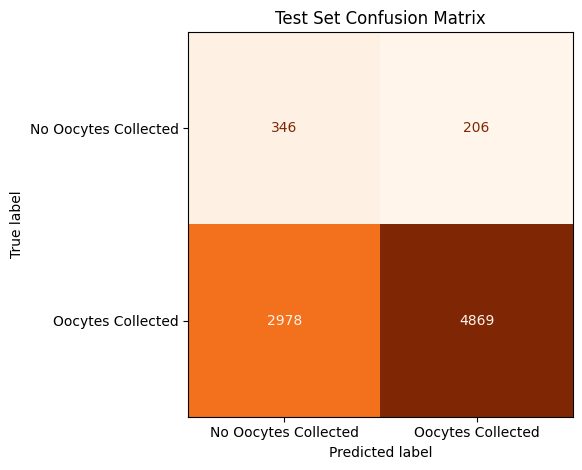

In [17]:
# Simple Logistic Regression with OPTIMAL THRESHOLD
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR = model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, Target='oocytes')

### Squared Logistic Regression (SLR)

Average optimal threshold = 0.938
AIC: -14994.419
BIC: -14413.292

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.623396,0.957502,0.679669,0.794953,0.667934
Standard Deviation,0.017974,0.003500,0.010940,0.007277,0.022812



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.628766,0.95847,0.670575,0.789083,0.676691


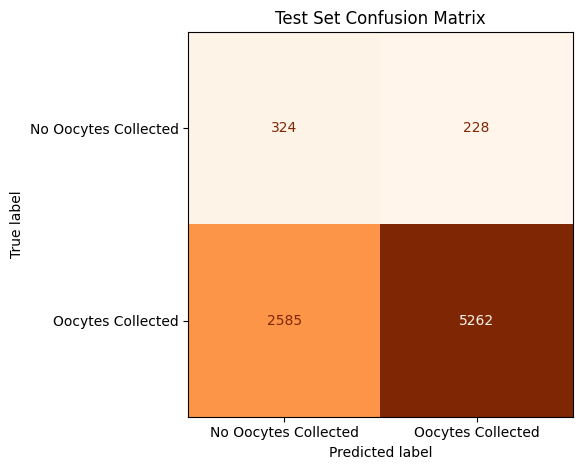

In [18]:
# Squared Logistic Regression with OPTIMAL THRESHOLD
X_train_eggs_poly = create_poly_features(X_train_eggs)
X_test_eggs_poly = create_poly_features(X_test_eggs)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':2000, 'random_state': 42}
results_LR2 = model_pipeline(X_train_eggs_poly, y_train_eggs, X_test_eggs_poly, y_test_eggs, model, metrics_list, params,
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, Target='oocytes')

### Random Forest (RF)

Average optimal threshold = 0.932

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.597325,0.951914,0.706066,0.810681,0.622687
Standard Deviation,0.015622,0.002701,0.014670,0.009946,0.017007



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.61013,0.954369,0.687651,0.799348,0.640713


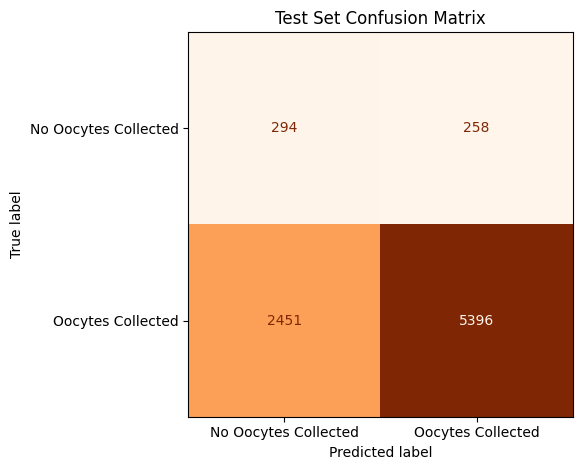

In [63]:
# Random Forest
model = RandomForestClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'n_estimators': 100}
results_RF = model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, Target='oocytes')

### XGBoost (XGB)

Average optimal threshold = 0.933

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.603831,0.953221,0.700812,0.807684,0.644642
Standard Deviation,0.015966,0.002805,0.013928,0.009373,0.019735



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.630249,0.958119,0.688034,0.80092,0.672093


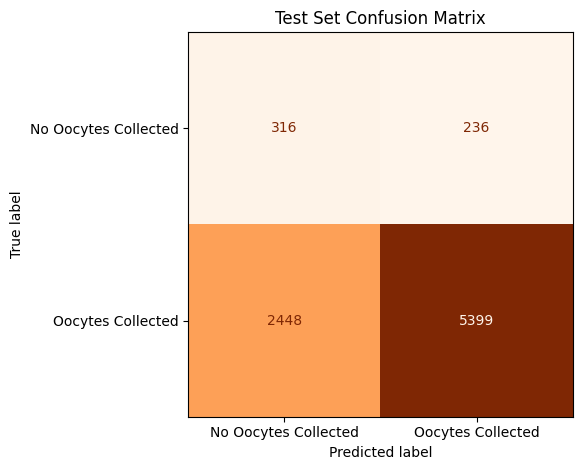

In [39]:
# XGBoost
model = XGBClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42}
results_XGB = model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, Target='oocytes')

### Multilayer Perceptron (MLP)

Average optimal threshold = 0.937

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.619816,0.956622,0.687120,0.799655,0.667657
Standard Deviation,0.020184,0.003973,0.015647,0.009880,0.022823



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.628991,0.956639,0.725373,0.825107,0.679376


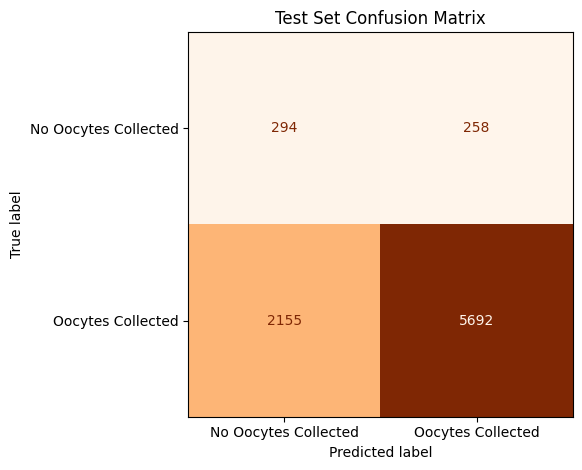

In [40]:
# Multilayer Perceptron
model = MLPClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 1000}
results_MLP = model_pipeline(X_train_eggs, y_train_eggs, X_test_eggs, y_test_eggs, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, Target='oocytes')

### Tuning the Squared Logistic Regression

Average optimal threshold = 0.504
AIC: -42164.354
BIC: -41583.227

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.618129,0.955394,0.715299,0.824326,0.661537
Standard Deviation,0.019752,0.003213,0.026413,0.015092,0.020565



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.633129,0.957639,0.717344,0.820255,0.673739


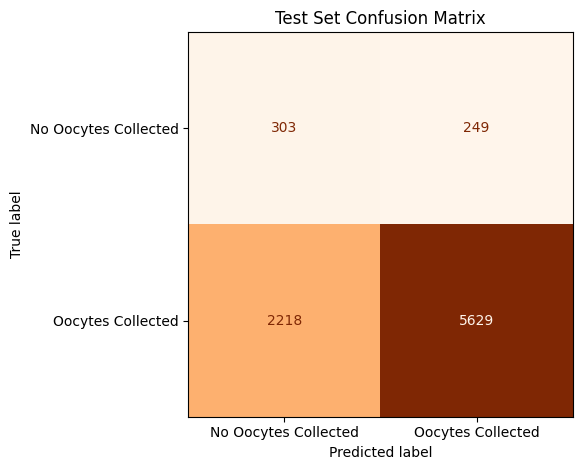

In [19]:
# Seeing if SMOTE improves performance - NO
X_train_eggs_poly = create_poly_features(X_train_eggs)
X_test_eggs_poly = create_poly_features(X_test_eggs)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':2000, 'random_state': 42}
results_LR2 = model_pipeline(X_train_eggs_poly, y_train_eggs, X_test_eggs_poly, y_test_eggs, model, metrics_list, params,
k=10, stratified=True, AIC=True, smote=True, SHAP=False, optimal_threshold=True, Target='oocytes')

#### Hyperparameter Tuning

In [40]:
model = LogisticRegression(penalty='l1', solver='saga', max_iter=6000, random_state = 42)

# Define the parameter grid for C
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# Call the compute_grid_search function
grid_search_result = compute_grid_search(model, param_grid, X_train_eggs_poly, y_train_eggs)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'C': 10}


#### Training the best model 

Average optimal threshold = 0.938

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.621422,0.957228,0.677090,0.792986,0.667747
Standard Deviation,0.018752,0.003677,0.018865,0.012908,0.022855



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.624347,0.95814,0.656302,0.779005,0.674661


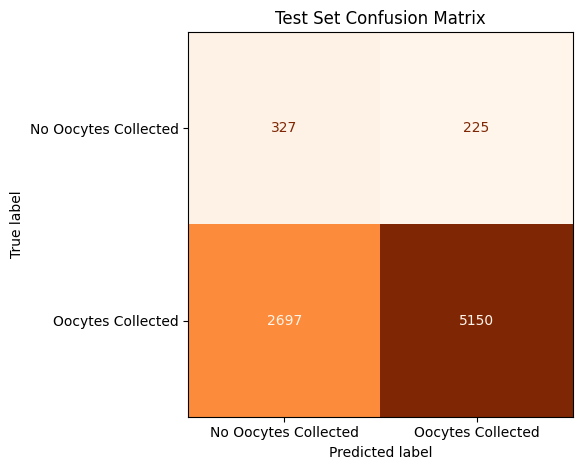


FEATURES ANALYSIS


,feature,importance_mean,importance_std
68,STIMULATION_USED SPERM_FROM,3.030643,0.108272
69,STIMULATION_USED SCREENING,1.318674,0.291270
52,CAUSE_OF_INFERTILITY__MALE_FACTOR STIMULATION_...,1.162872,0.092901
59,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED SPER...,1.151222,0.185854
45,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER STIMU...,1.125649,0.153230
7,STIMULATION_USED,1.087677,0.049175
67,STIMULATION_USED^2,1.087677,0.049175
58,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED STIM...,0.923913,0.073432
73,SPERM_FROM PREVIOUS_LIVE_BIRTH_IVF_OR_DI,0.840958,0.182299
35,CAUSE__OF_INFERTILITY__TUBAL_DISEASE CAUSE_OF_...,0.833190,0.146440


In [24]:
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'penalty': 'l1', 'C':10, 'solver':'saga', 'random_state': 42, 'max_iter': 6000}
results_BEST = model_pipeline(X_train_eggs_poly, y_train_eggs, X_test_eggs_poly, y_test_eggs, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, importances=True, Target='oocytes')

In [59]:
print('The number of non zero coefficients is: '+str((results_BEST['feature_importances']['importance_mean'] >= 0).sum()))

The number of non zero coefficients is: 77


In [61]:
with open('STAGE_1_PREDICTIONS.txt', 'w') as f:
    for item in results_BEST['y_test_pred']:
        f.write("%s\n" % item)

#

## **STAGE 2 MODELS**

In [20]:
def read_list_from_file(filename):
    # Try to open and read the file

    with open(filename, 'r') as f:
        list_from_file = f.readlines()

    # Remove newline characters
    list_from_file = [item.strip() for item in list_from_file]

    # Convert strings to floats
    list_from_file = [float(item) for item in list_from_file]

    return list_from_file

In [21]:
STAGE_1_PREDICTIONS = read_list_from_file('STAGE_1_PREDICTIONS.txt')

In [22]:
# Update the test data with the stage 1 predictions to filter on
X_test_embryos['EGGS_COLLECTED_BINARY'] = STAGE_1_PREDICTIONS
X_test_embryos = X_test_embryos[X_test_embryos['EGGS_COLLECTED_BINARY'] != 0]
y_test_embryos = X_test_embryos['EMBRYOS_CREATED_BINARY']
X_test_embryos = X_test_embryos.drop(['EGGS_COLLECTED_BINARY', 'EMBRYOS_CREATED_BINARY'], axis=1)

In [23]:
X_test_embryos.shape

(5375, 12)

### Logistic Regression (LR)

Average optimal threshold = 0.945
AIC: -12373.934
BIC: -12265.323

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.609690,0.963545,0.696656,0.808072,0.649107
Standard Deviation,0.017619,0.002831,0.036558,0.024458,0.023789



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.610569,0.939523,0.845267,0.889906,0.687716


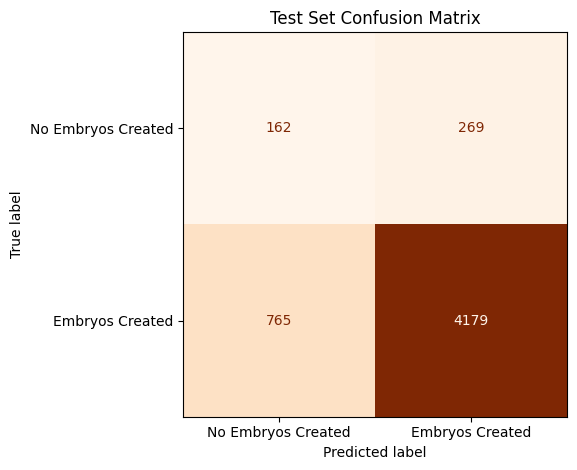

In [24]:
# Simple Logistic Regression with OPTIMAL THRESHOLD
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42}
results_LR = model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, Target='embryos')

### Squared Logistic Regression (SLR)

Average optimal threshold = 0.51
AIC: -40217.275
BIC: -39540.543

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.611102,0.965638,0.626555,0.759001,0.659107
Standard Deviation,0.017974,0.003311,0.045350,0.032647,0.022945



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.626133,0.944041,0.788228,0.859127,0.701008


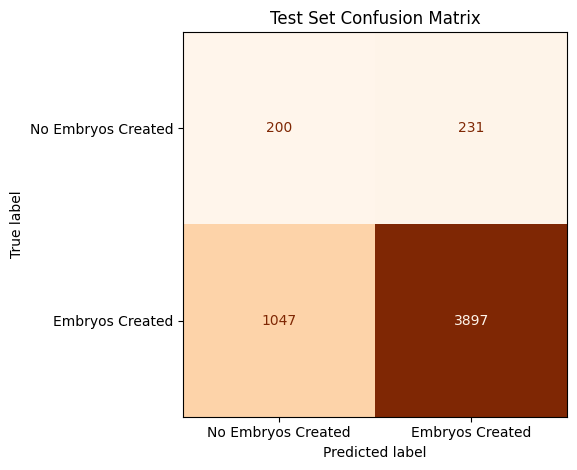

In [25]:
# Squared Logistic Regression with OPTIMAL THRESHOLD
X_train_embryos_poly = create_poly_features(X_train_embryos)
X_test_embryos_poly = create_poly_features(X_test_embryos)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':2000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2 = model_pipeline(X_train_embryos_poly, y_train_embryos, X_test_embryos_poly, y_test_embryos, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, Target='embryos')

### Random Forest (RF)

Average optimal threshold = 0.947

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.587183,0.960435,0.680759,0.796626,0.604831
Standard Deviation,0.017200,0.002398,0.019116,0.013430,0.025793



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.591265,0.937485,0.776497,0.84943,0.633949


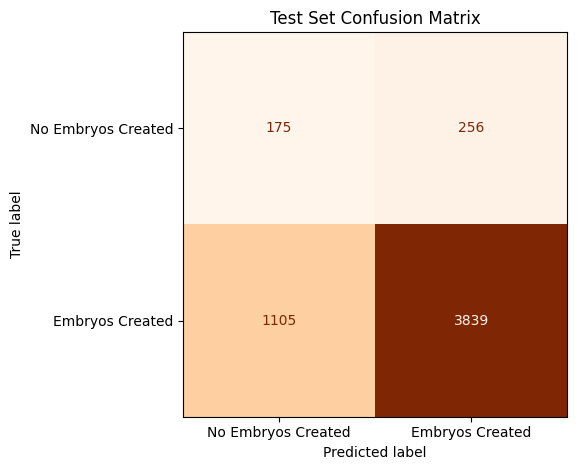

In [26]:
# Random Forest
model = RandomForestClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'n_estimators': 100}
results_RF = model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, Target='embryos')

### XGBoost (XGB)

Average optimal threshold = 0.997

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.593069,0.960743,0.712579,0.817878,0.630512
Standard Deviation,0.009997,0.001492,0.030693,0.020103,0.020418



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.594095,0.936222,0.861044,0.89706,0.655426


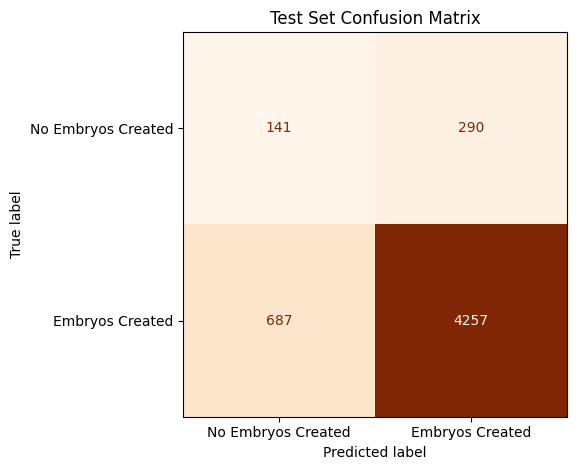

In [27]:
# XGBoost
counter = Counter(y_train_embryos)
estimate = counter[1] / counter[0]
model = XGBClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'scale_pos_weight': estimate}
results_XGB = model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, Target='embryos')

### Multilayer Perceptron (MLP)

Average optimal threshold = 0.95

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.605933,0.963741,0.664194,0.785503,0.653912
Standard Deviation,0.013248,0.002264,0.044902,0.031688,0.022306



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.616205,0.94443,0.715008,0.81386,0.692868


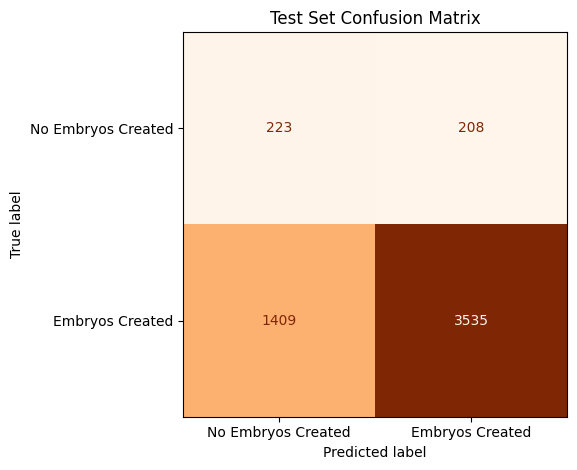

In [28]:
# Multilayer Perceptron
model = MLPClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 1000}
# hyperparams={'model__hidden_layer_sizes': [(50,), (100,), (150,)]
results_MLP = model_pipeline(X_train_embryos, y_train_embryos, X_test_embryos, y_test_embryos, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, Target='embryos')

### Tuning the Squared Logistic Regression

In [52]:
model = LogisticRegression(penalty='l1', solver='saga', max_iter=6000, random_state = 42, class_weight='balanced')

# Define the parameter grid for C
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# Call the compute_grid_search function
grid_search_result = compute_grid_search(model, param_grid, X_train_embryos_poly, y_train_embryos)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'C': 1}


Average optimal threshold = 0.513
AIC: -39816.458
BIC: -39139.725

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.606569,0.964447,0.639595,0.777295,0.649535
Standard Deviation,0.023609,0.004155,0.046677,0.020632,0.025014



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.619821,0.942969,0.782565,0.855311,0.689189


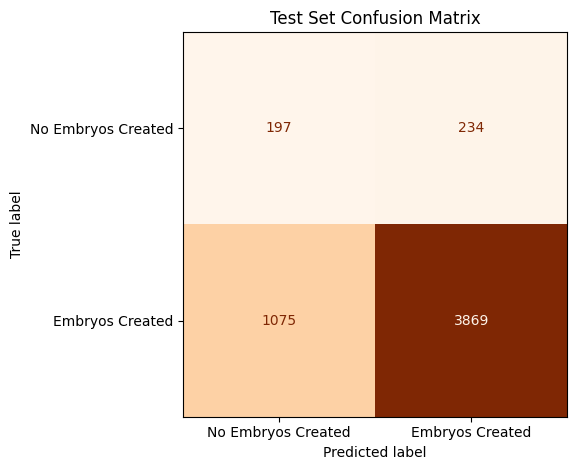

In [29]:
# Seeing if SMOTE improves performance
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 3000, 'n_jobs':-1}
results_BEST2 = model_pipeline(X_train_embryos_poly, y_train_embryos, X_test_embryos_poly, y_test_embryos, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=True, SHAP=False, optimal_threshold=True, importances=False, Target='embryos')

#### Training the best model

Average optimal threshold = 0.514
AIC: -40236.668
BIC: -39476.388

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.612084,0.966055,0.620638,0.754567,0.659255
Standard Deviation,0.020541,0.004030,0.049425,0.034873,0.023108



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.625252,0.944444,0.770227,0.848485,0.702602


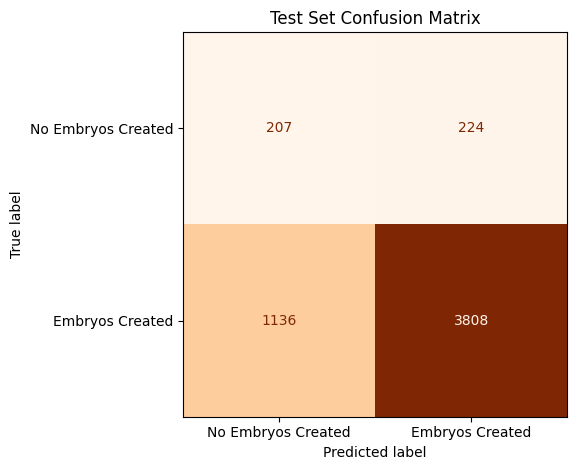


FEATURES ANALYSIS


,feature,importance_mean,importance_std
50,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER SPERM...,2.408199,0.078631
21,PATIENT_AGE_AT_TREATMENT SCREENING,1.451637,0.017577
63,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED CAUS...,1.236009,0.598528
64,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED STIM...,1.146612,0.091955
47,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER CAUSE...,0.960901,0.273543
48,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER CAUSE...,0.820984,0.161695
39,CAUSE__OF_INFERTILITY__TUBAL_DISEASE CAUSE_OF_...,0.806853,0.057565
41,CAUSE__OF_INFERTILITY__TUBAL_DISEASE SPERM_FROM,0.724324,0.294827
38,CAUSE__OF_INFERTILITY__TUBAL_DISEASE CAUSE_OF_...,0.714228,0.209676
40,CAUSE__OF_INFERTILITY__TUBAL_DISEASE STIMULATI...,0.707881,0.141192


In [131]:
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'penalty': 'l1', 'C':1, 'solver':'saga', 'random_state': 42, 'max_iter': 6000, 'class_weight': 'balanced', 'n_jobs':-1}
results_BEST2 = model_pipeline(X_train_embryos_poly, y_train_embryos, X_test_embryos_poly, y_test_embryos, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True, Target='embryos')

In [56]:
print('The number of non zero coefficients is: '+str((results_BEST2['feature_importances']['importance_mean'] >= 0.001).sum()))

The number of non zero coefficients is: 82


In [57]:
with open('STAGE_2_PREDICTIONS.txt', 'w') as f:
    for item in results_BEST2['y_test_pred']:
        f.write("%s\n" % item)

In [258]:
STAGE_2_PREDICTIONS = read_list_from_file('STAGE_2_PREDICTIONS.txt')

#### Compute overall test metrics over the 2 stages

In [259]:
X_test_embryos_predicted = X_test_embryos.copy()
X_test_embryos_predicted['EMBRYOS_CREATED_BINARY'] = STAGE_2_PREDICTIONS
Stage_2_predictions_indexed = X_test_embryos_predicted['EMBRYOS_CREATED_BINARY']

In [260]:
X_test_oocytes_embryos = X_test_eggs.copy()
X_test_oocytes_embryos['EMBRYOS_CREATED_BINARY'] = Stage_2_predictions_indexed
X_test_oocytes_embryos['EMBRYOS_CREATED_BINARY'].fillna(0, inplace=True)

In [261]:
y_test_embryos_true = TEST['EMBRYOS_CREATED_BINARY']
y_test_embryos_pred = X_test_oocytes_embryos['EMBRYOS_CREATED_BINARY']

F1 Score: 0.6613407433136506
Precision: 0.9444444444444444
Precision: 0.5088188134687333
Balanced Accuracy: 0.6320050351496671



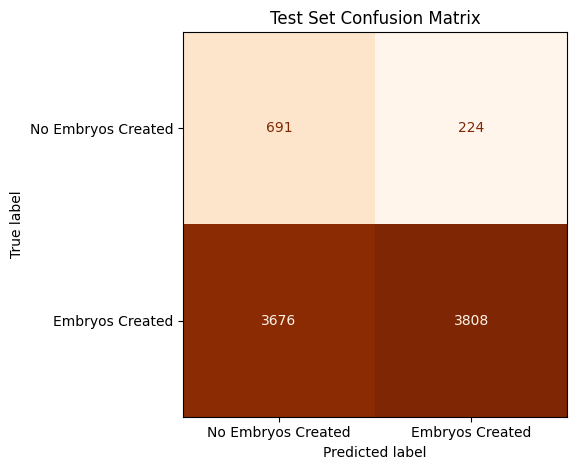

In [75]:
print('F1 Score: '+str(f1_score(y_test_embryos_true, y_test_embryos_pred)))
print('Precision: '+str(precision_score(y_test_embryos_true, y_test_embryos_pred)))
print('Precision: '+str(recall_score(y_test_embryos_true, y_test_embryos_pred)))
print('Balanced Accuracy: '+str(balanced_accuracy_score(y_test_embryos_true, y_test_embryos_pred)))
print('')
conf_matrix = confusion_matrix(y_test_embryos_true, y_test_embryos_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Embryos Created', 'Embryos Created'])
disp.plot(cmap="Oranges",  colorbar=False)
plt.title('Test Set Confusion Matrix')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_stage2.png', bbox_inches='tight', dpi=600)
plt.show()

### Training a baseline SLR model for embryo prediction in a single stage

In [98]:
TRAIN_temp = pd.read_parquet('TRAIN_2016.parquet')
TEST_temp = pd.read_parquet('TEST_2016.parquet')

# Convert TOTAL_EMBRYOS_CREATED to binary
TRAIN_temp['TOTAL_EMBRYOS_CREATED'] = (TRAIN_temp['TOTAL_EMBRYOS_CREATED'] > 0).astype(int)
TRAIN_temp.rename(columns={'TOTAL_EMBRYOS_CREATED': 'EMBRYOS_CREATED_BINARY'}, inplace=True)

TEST_temp['TOTAL_EMBRYOS_CREATED'] = (TEST_temp['TOTAL_EMBRYOS_CREATED'] > 0).astype(int)
TEST_temp.rename(columns={'TOTAL_EMBRYOS_CREATED': 'EMBRYOS_CREATED_BINARY'}, inplace=True)

In [106]:
X_train_embryos_full = TRAIN_temp.drop(['FRESH_EGGS_COLLECTED', 'EMBRYOS_CREATED_BINARY', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
y_train_embryos_full = TRAIN_temp['EMBRYOS_CREATED_BINARY']

X_test_embryos_full = TEST_temp.drop(['FRESH_EGGS_COLLECTED', 'EMBRYOS_CREATED_BINARY', 'LIVE_BIRTH_OCCURRENCE'], axis=1)
y_test_embryos_full = TEST_temp['EMBRYOS_CREATED_BINARY']

Average optimal threshold = 0.876

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.696364,0.943202,0.758340,0.839965,0.772315
Standard Deviation,0.012077,0.004008,0.043605,0.026764,0.011661



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.693192,0.943293,0.760155,0.841879,0.765753


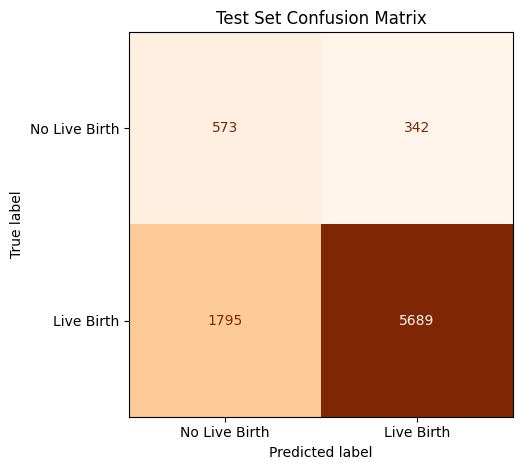

In [241]:
model = LogisticRegression

X_train_embryos_full_poly = create_poly_features(X_train_embryos_full)
X_test_embryos_full_poly = create_poly_features(X_test_embryos_full)

metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 6000}
results_stage2baseline = model_pipeline(X_train_embryos_full_poly, y_train_embryos_full, X_test_embryos_full_poly, y_test_embryos_full, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True, importances=False, Target='embryos')

In [242]:
with open('STAGE_2_BASELINE.txt', 'w') as f:
    for item in results_stage2baseline['y_test_pred']:
        f.write("%s\n" % item)

#

## **STAGE 3 MODELS**

In [262]:
# Update the test data with the stage 2 predictions to filter on
X_test_live_birth['EMBRYOS_CREATED_BINARY'] = y_test_embryos_pred
X_test_live_birth = X_test_live_birth[X_test_live_birth['EMBRYOS_CREATED_BINARY'] != 0]
y_test_live_birth = X_test_live_birth['LIVE_BIRTH_OCCURRENCE']
X_test_live_birth = X_test_live_birth.drop(['EMBRYOS_CREATED_BINARY', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

### Logistic Regression (LR)

Average optimal threshold = 0.474
AIC: -39560.634
BIC: -39452.68

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.596336,0.368372,0.759931,0.496117,0.630041
Standard Deviation,0.006615,0.003764,0.024963,0.007577,0.008383



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.521247,0.3452,0.878248,0.495601,0.534058


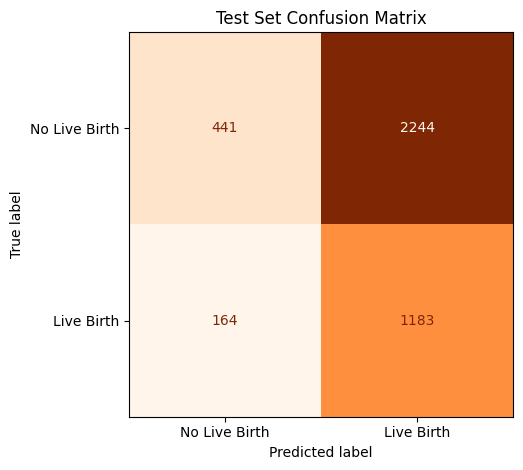

In [263]:
# Simple Logistic Regression with OPTIMAL THRESHOLD
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':1000, 'random_state': 42, 'class_weight':'balanced'}
results_LR = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

### Squared Logistic Regression (SLR)

Average optimal threshold = 0.509
AIC: -39221.316
BIC: -38465.639

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.597675,0.373485,0.725927,0.492974,0.630595
Standard Deviation,0.007372,0.006518,0.028255,0.007480,0.008806



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.525025,0.347773,0.846325,0.492973,0.531243


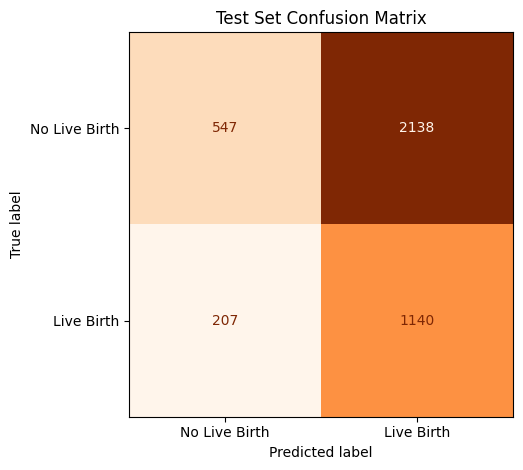

In [214]:
# Squared Logistic Regression with OPTIMAL THRESHOLD
X_train_live_birth_poly = create_poly_features(X_train_live_birth)
X_test_live_birth_poly = create_poly_features(X_test_live_birth)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':2000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2 = model_pipeline(X_train_live_birth_poly, y_train_live_birth, X_test_live_birth_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

### Random Forest (RF)

Average optimal threshold = 0.485

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.585973,0.364642,0.712668,0.482348,0.607194
Standard Deviation,0.008802,0.006372,0.022207,0.008957,0.012350



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.522805,0.34665,0.837416,0.490328,0.527405


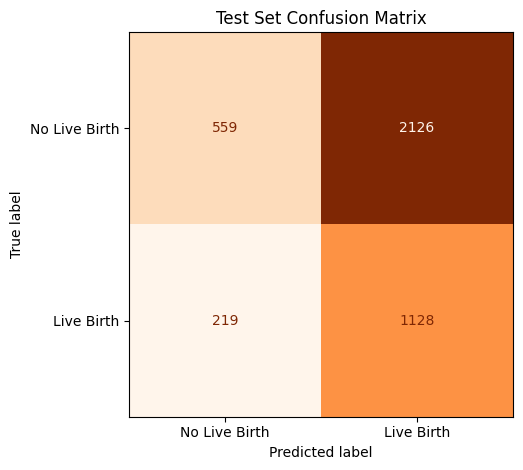

In [218]:
# Random Forest
model = RandomForestClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'n_estimators': 100, 'class_weight': 'balanced'}
results_RF = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

### XGBoost (XGB)

Average optimal threshold = 0.024

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.594101,0.370634,0.723058,0.489857,0.624833
Standard Deviation,0.005757,0.005055,0.027368,0.006377,0.009244



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.522044,0.346072,0.847068,0.491387,0.534945


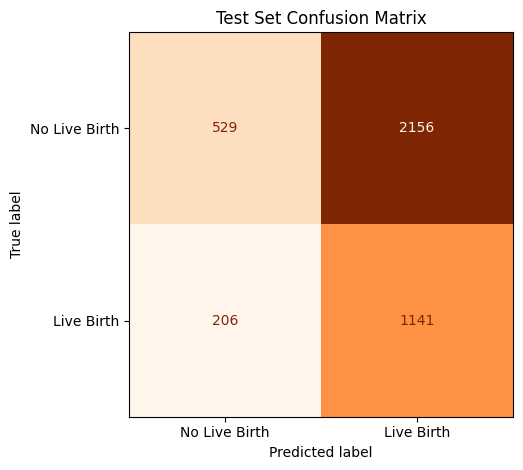

In [217]:
# XGBoost
counter = Counter(y_train_embryos)
estimate = counter[0] / counter[1]
model = XGBClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'scale_pos_weight': estimate}
results_XGB = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

### Multilayer Perceptron (MLP)

Average optimal threshold = 0.308

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.596896,0.372416,0.728793,0.492828,0.626701
Standard Deviation,0.008716,0.007131,0.019098,0.007904,0.010167



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.523535,0.346926,0.846325,0.492122,0.532673


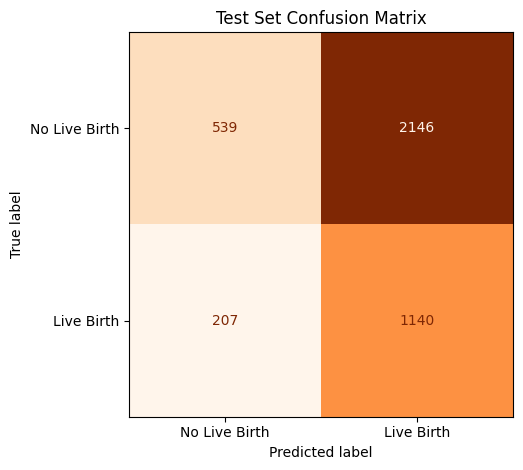

In [219]:
# Multilayer Perceptron
model = MLPClassifier
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 1000}
# hyperparams={'model__hidden_layer_sizes': [(50,), (100,), (150,)]
results_MLP = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=False, smote=False, SHAP=False, optimal_threshold=True)

### Tuning the Logistic Regression

In [264]:
model = LogisticRegression(penalty='l1', solver='saga', max_iter=6000, random_state = 42, class_weight='balanced')

# Define the parameter grid for C
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# Call the compute_grid_search function
grid_search_result = compute_grid_search(model, param_grid, X_train_live_birth, y_train_live_birth)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'C': 0.001}


Average optimal threshold = 0.509
AIC: -39259.282
BIC: -38503.605

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.595940,0.372778,0.737073,0.492541,0.629240
Standard Deviation,0.008552,0.007216,0.026399,0.009250,0.009187



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.520711,0.345083,0.864885,0.493331,0.532151


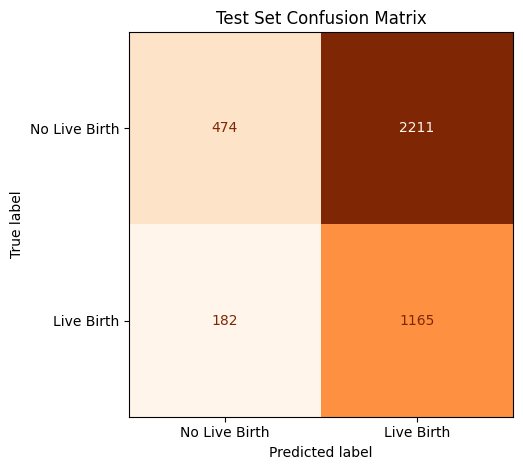

In [225]:
# Seeing if SMOTE improves performance - NO
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'random_state': 42, 'max_iter': 3000, 'n_jobs':-1}
results_BEST2 = model_pipeline(X_train_live_birth_poly, y_train_live_birth, X_test_live_birth_poly, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=True, SHAP=False, optimal_threshold=True, importances=False)

### Training the best model

Average optimal threshold = 0.5
AIC: -39817.765
BIC: -39709.811

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.595767,0.363633,0.804658,0.500886,0.618116
Standard Deviation,0.005263,0.003477,0.010998,0.004698,0.007555



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.533125,0.357254,0.68003,0.468422,0.53794


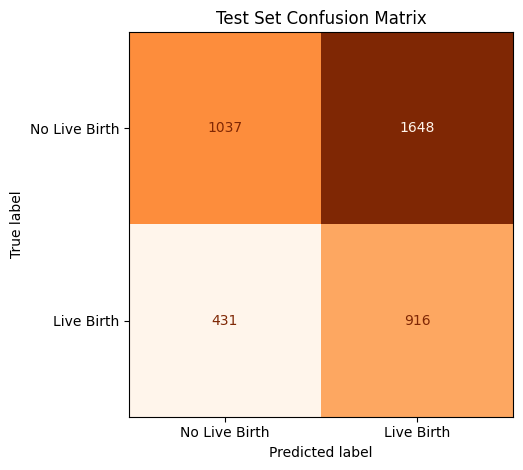


FEATURES ANALYSIS


,feature,importance_mean,importance_std
0,PATIENT_AGE_AT_TREATMENT,0.300984,0.002444
1,TOTAL_NUMBER_OF_PREVIOUS_CYCLES_BOTH_IVF_AND_DI,0.000000,0.000000
2,CAUSE__OF_INFERTILITY__TUBAL_DISEASE,0.000000,0.000000
3,CAUSE_OF_INFERTILITY__OVULATORY_DISORDER,0.000000,0.000000
4,CAUSE_OF_INFERTILITY__MALE_FACTOR,0.000000,0.000000
5,CAUSE_OF_INFERTILITY__PATIENT_UNEXPLAINED,0.000000,0.000000
6,CAUSE_OF_INFERTILITY__ENDOMETRIOSIS,0.000000,0.000000
7,STIMULATION_USED,0.000000,0.000000
8,SPERM_FROM,0.000000,0.000000
9,SCREENING,0.000000,0.000000


In [294]:
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'penalty': 'l1', 'C':0.001, 'solver':'saga', 'random_state': 42, 'max_iter': 6000, 'class_weight': 'balanced', 'n_jobs':-1}
results_BEST3 = model_pipeline(X_train_live_birth, y_train_live_birth, X_test_live_birth, y_test_live_birth, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True, importances=True)

In [295]:
with open('STAGE_3_PREDICTIONS.txt', 'w') as f:
    for item in results_BEST3['y_test_pred']:
        f.write("%s\n" % item)

In [296]:
STAGE_3_PREDICTIONS = read_list_from_file('STAGE_3_PREDICTIONS.txt')

#### Compute overall test metrics over the 3 stages

In [297]:
X_test_lb_predicted = X_test_live_birth.copy()
X_test_lb_predicted['LIVE_BIRTH_OCCURRENCE'] = STAGE_3_PREDICTIONS
Stage_3_predictions_indexed = X_test_lb_predicted['LIVE_BIRTH_OCCURRENCE']

X_test_oocytes_embryos_lb = X_test_eggs.copy()
X_test_oocytes_embryos_lb['LIVE_BIRTH_OCCURRENCE'] = Stage_3_predictions_indexed
X_test_oocytes_embryos_lb['LIVE_BIRTH_OCCURRENCE'].fillna(0, inplace=True)

y_test_lb_true = TEST['LIVE_BIRTH_OCCURRENCE']
y_test_lb_pred = X_test_oocytes_embryos_lb['LIVE_BIRTH_OCCURRENCE']

F1 Score: 0.3793746117208532
Precision: 0.35725429017160687
Precision: 0.4044150110375276
Balanced Accuracy: 0.5678742808692692



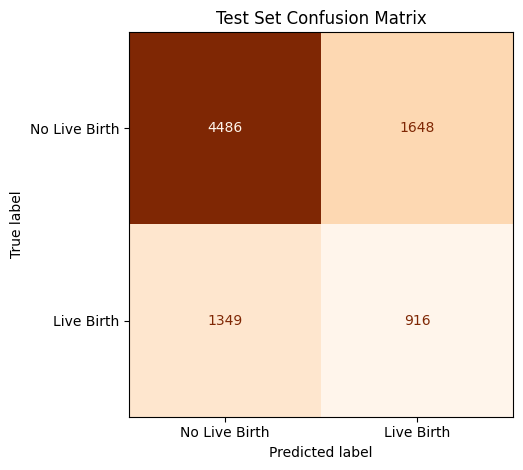

In [298]:
print('F1 Score: '+str(f1_score(y_test_lb_true, y_test_lb_pred)))
print('Precision: '+str(precision_score(y_test_lb_true, y_test_lb_pred)))
print('Precision: '+str(recall_score(y_test_lb_true, y_test_lb_pred)))
print('Balanced Accuracy: '+str(balanced_accuracy_score(y_test_lb_true, y_test_lb_pred)))
print('')
conf_matrix = confusion_matrix(y_test_lb_true, y_test_lb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Live Birth', 'Live Birth'])
disp.plot(cmap="Oranges",  colorbar=False)
plt.title('Test Set Confusion Matrix')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_stage3.png', bbox_inches='tight', dpi=600)
plt.show()

## Two-stage Model (Embryos Created + Live Birth)

In [277]:
TEST2 = pd.read_parquet('TEST_2016.parquet')
X_test_live_birth2 = TEST2.copy()

In [278]:
STAGE_2_BASELINE_PREDICTIONS = read_list_from_file('STAGE_2_BASELINE.txt')

In [279]:
# Update the test data with the stage 2 predictions to filter on
X_test_live_birth2['EMBRYOS_CREATED_BINARY'] = STAGE_2_BASELINE_PREDICTIONS
X_test_live_birth2 = X_test_live_birth2[X_test_live_birth2['EMBRYOS_CREATED_BINARY'] != 0]
y_test_live_birth2 = X_test_live_birth2['LIVE_BIRTH_OCCURRENCE']
X_test_live_birth2 = X_test_live_birth2.drop(['FRESH_EGGS_COLLECTED', 'TOTAL_EMBRYOS_CREATED', 'EMBRYOS_CREATED_BINARY', 'LIVE_BIRTH_OCCURRENCE'], axis=1)

Average optimal threshold = 0.509
AIC: -39221.316
BIC: -38465.639

CV RESULTS


,accuracy,precision,recall,f1_score,auc
Mean,0.597675,0.373485,0.725927,0.492974,0.630595
Standard Deviation,0.007372,0.006518,0.028255,0.007480,0.008806



TEST RESULTS


,accuracy,precision,recall,f1_score,auc
Value,0.569797,0.348715,0.761853,0.478439,0.590456


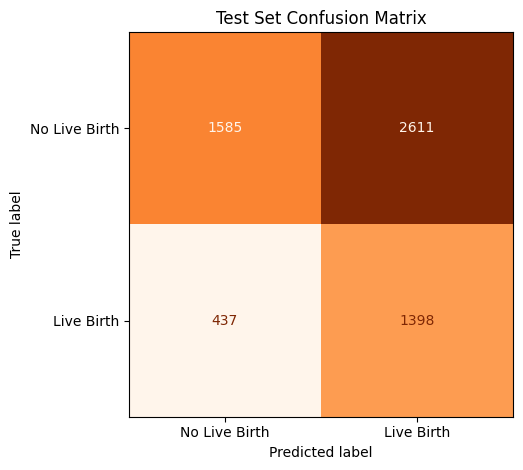

In [284]:
# Squared Logistic Regression with OPTIMAL THRESHOLD
X_train_live_birth_poly2 = create_poly_features(X_train_live_birth)
X_test_live_birth_poly2 = create_poly_features(X_test_live_birth2)
model = LogisticRegression
metrics_list = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
params = {'max_iter':2000, 'random_state': 42, 'class_weight': 'balanced'}
results_LR2_2 = model_pipeline(X_train_live_birth_poly2, y_train_live_birth, X_test_live_birth_poly2, y_test_live_birth2, model, metrics_list, params, 
k=10, stratified=True, AIC=True, smote=False, SHAP=False, optimal_threshold=True)

In [285]:
with open('STAGE_3_BASELINE.txt', 'w') as f:
    for item in results_LR2_2['y_test_pred']:
        f.write("%s\n" % item)

In [286]:
STAGE_3_BASELINE_PREDICTIONS = read_list_from_file('STAGE_3_BASELINE.txt')

In [290]:
X_test_lb_predicted2 = X_test_live_birth2.copy()
X_test_lb_predicted2['LIVE_BIRTH_OCCURRENCE'] = STAGE_3_BASELINE_PREDICTIONS
Stage_3_baseline_predictions_indexed = X_test_lb_predicted2['LIVE_BIRTH_OCCURRENCE']

X_test_oocytes_embryos_lb2 = X_test_eggs.copy()
X_test_oocytes_embryos_lb2['LIVE_BIRTH_OCCURRENCE'] = Stage_3_baseline_predictions_indexed
X_test_oocytes_embryos_lb2['LIVE_BIRTH_OCCURRENCE'].fillna(0, inplace=True)

y_test_lb_true2 = TEST['LIVE_BIRTH_OCCURRENCE']
y_test_lb_pred2 = X_test_oocytes_embryos_lb2['LIVE_BIRTH_OCCURRENCE']

F1 Score: 0.4456487089576028
Precision: 0.34871539037166377
Recall: 0.6172185430463576
Balanced Accuracy: 0.5957791443630875



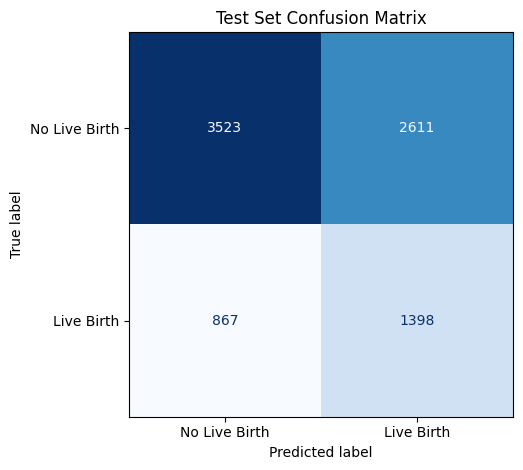

In [299]:
print('F1 Score: '+str(f1_score(y_test_lb_true2, y_test_lb_pred2)))
print('Precision: '+str(precision_score(y_test_lb_true2, y_test_lb_pred2)))
print('Recall: '+str(recall_score(y_test_lb_true2, y_test_lb_pred2)))
print('Balanced Accuracy: '+str(balanced_accuracy_score(y_test_lb_true2, y_test_lb_pred2)))
print('')
conf_matrix = confusion_matrix(y_test_lb_true2, y_test_lb_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Live Birth', 'Live Birth'])
disp.plot(cmap="Blues",  colorbar=False)
plt.title('Test Set Confusion Matrix')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_stage3_baseline.png', bbox_inches='tight', dpi=600)
plt.show()